## Setup

In [1]:
from evaluate import *
import pandas as pd
from sklearn.model_selection import LeaveOneOut
import warnings
from collections import Counter
from itertools import combinations
import os
import pickle

In [2]:
data_root = r'RSRM\data\SR\\'

In [3]:
dataset='s'
regression = True if dataset == 's' else False
tt = 'loo_mae' if regression else 'loo_tss'
cv_info = f'Treated results/{dataset}_folds.txt'
linear_cv_data = f'Treated results/linear_{dataset}_cross_validation.csv'
pysr_cv_data = f'Treated results/pysr_{dataset}_cross_validation.csv'
rsrm_cv_data = f'Treated results/rsrm_{dataset}_cross_validation.csv'
data_file = f'{dataset}'

In [4]:
folds = read_train_test_indices(cv_info)
dataset_name = {'lepthyphantes': 'canariphantes', 'alestrus': 'alestrus', 's': 'species richness'}[dataset]
dataset_name = dataset_name.capitalize()
if regression:
    metric = 'Pseudo R²'
else:
    metric = 'TSS'
linear_df_o = pd.read_csv(linear_cv_data)
pysr_df_o = pd.read_csv(pysr_cv_data)
rsrm_df_o = pd.read_csv(rsrm_cv_data)
X1, y1 = load_dataset(data_root + data_file + '_train.csv')
X2, y2 = load_dataset(data_root + data_file + '_test.csv')
X = pd.concat([X1, X2], ignore_index=True) 
y = pd.concat([y1, y2], ignore_index=True).astype(int)
get_fold = get_fold_wrapper(X, y, folds)
originals = {'linear': linear_df_o, 'pysr': pysr_df_o, 'rsrm': rsrm_df_o}

In [5]:
linear_df = pd.DataFrame(columns=['run', 'equation', 'complexity', 'train', 'test'])
pysr_df = pd.DataFrame(columns=['run', 'equation', 'complexity', 'train', 'test'])
rsrm_df = pd.DataFrame(columns=['run', 'equation', 'complexity', 'train', 'test'])
new_ones = {'linear': linear_df, 'pysr': pysr_df, 'rsrm': rsrm_df}
predictions = {}
for key in originals.keys():
    new_df = new_ones[key]
    original_df = originals[key]
    new_df['skeleton'] = original_df['Equation'].apply(replace_numeric_parameters)
    new_df['run'] = original_df['Run']
    new_df['complexity'] = original_df['Equation'].apply(count_weighted_operations)
    new_df.drop(new_df[new_df['complexity'] == 0].index, inplace=True)
    new_df.drop(new_df[new_df['complexity'] > 20].index, inplace=True)
    new_df['train'] = original_df[f'{metric} (train)'].astype(float)
    new_df['test'] = original_df[f'{metric} (test)'].astype(float)
    new_df['equation'] = original_df['Equation']
    new_df['lambda'] = lambdify_equations(new_df['equation'], X.columns.tolist())
    if not regression:
        for run in range(1, new_df['run'].nunique() + 1):
            X_train, y_train, X_test, y_test = get_fold(run)
            rows =  new_df[new_df['run'] == run]
            thresholds = rows['lambda'].apply(lambda func: get_threshold(func, X_train, y_train))
            new_df.loc[new_df['run'] == run, 'thresholds'] = thresholds.round(3)

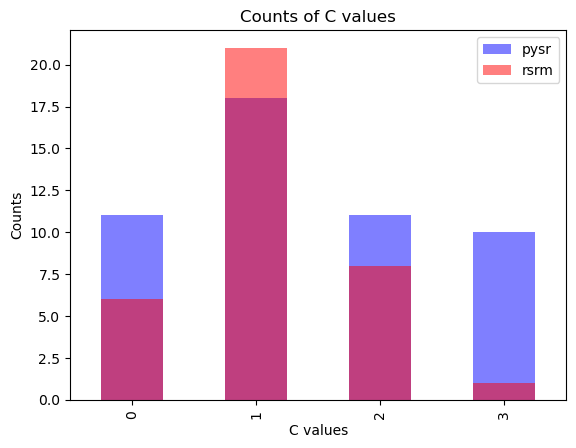

In [6]:
fig, ax = plt.subplots()
x = pysr_df['skeleton'].apply(lambda x: len(replace_placeholders(x)[1])).value_counts().sort_index()
x.plot(kind='bar', color='blue', label='pysr', alpha=0.5)
x = rsrm_df['skeleton'].apply(lambda x: len(replace_placeholders(x)[1])).value_counts().sort_index()
x.plot(kind='bar', color='red', label='rsrm', alpha=0.5)
ax.set_xlabel('C values')
ax.set_ylabel('Counts')
ax.set_title('Counts of C values')
ax.legend()

### Run

#### Species Richness

In [ ]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define regression settings
if regression:
    loss = 'poisson'
    metric = mae
    metric_name = 'mae'
else:
    loss = 'bce'
    metric = true_skill_statistic
    metric_name = 'tss'

# Create a directory to save the files
output_dir = "saved_data"
os.makedirs(output_dir, exist_ok=True)

# Initialize a dictionary to store parameters (Cs)
parameters_dict = {}

# Iterate over the keys in originals
for key in originals.keys():
    df_filename = os.path.join(output_dir, f"{dataset}_{key}_dataframe.csv")
    params_filename = os.path.join(output_dir, f"parameters_{dataset}.pkl")

    # Check if the DataFrame and parameters already exist
    if os.path.exists(df_filename) and os.path.exists(params_filename):
        print(f"Loading precomputed data for {key}...")
        globals()[f'{key}_df'] = pd.read_csv(df_filename)
        new_ones[key] = globals()[f'{key}_df']
        with open(params_filename, "rb") as f:
            parameters_dict = pickle.load(f)
    else:
        print(f"Computing data for {key}...")
        use_glm = key == 'linear'
        new_df = new_ones[key]
        scores = []
        eq_params_list = []  # To store parameters for each equation in this key

        for eq_str in new_df['equation']:
            eq_skel = replace_numeric_parameters(eq_str)
            original_params = extract_numeric_parameters(eq_str)
            print('Assessing ', eq_skel)
            loo = LeaveOneOut()
            initial_guess = original_params
            minimizer_kwargs = {"method": "Powell", "options": {"ftol":1e-3}}
            preds = []

            for train_index, test_index in loo.split(X):
                X_train, X_test = X.loc[train_index], X.loc[test_index]
                y_train, y_test = y.loc[train_index], y.loc[test_index]
                X_train_s = normalize_by_iqr(X_train)
                X_test_s = normalize_by_iqr(X_test, X_train)

                # Optimize equation and get parameters (Cs)
                Cs, min = optimize_equation(eq_skel, X_train_s, y_train, variables=X.columns.tolist(), loss=loss, initial_guess=original_params, basinhop=False, use_glm=use_glm, **minimizer_kwargs)
                eqstr_params = replace_optimized_parameters(eq_skel, original_params)
                ll = lambdify_equations([eqstr_params], variables=X.columns.tolist())[0]
                y_pred = ll(X_test_s)
                preds.append(y_pred.item())

            preds = np.array(preds)
            if not regression:
                if key != 'linear':
                    preds = sigmoid(preds)
                preds = binarize_predictions(preds)
            val = metric(y, preds)
            scores.append(val)
            eq_params_list.append(Cs)  # Store parameters for this equation

        # Add scores to the DataFrame
        new_df[f'loo_{metric_name}'] = scores
        # Print results for this key
        print(f"Results for {key}:")
        print(scores)

        # Save the DataFrame to disk
        df_tosave = new_df.drop(columns=['lambda'])
        df_tosave.to_csv(df_filename, index=False)
        print(f"Saved DataFrame for {key} to {df_filename}")

        # Save parameters for this key
        parameters_dict[key] = eq_params_list
        with open(params_filename, "wb") as f:
            pickle.dump(parameters_dict, f)
        print(f"Saved parameters to {params_filename}")

Loading precomputed data for linear...
Loading precomputed data for pysr...
Loading precomputed data for rsrm...


In [28]:
from collections import Counter
from itertools import combinations
import pandas as pd

counts_dict = {}

for key in originals.keys():
    new_df = new_ones[key]
    eqs_per_run = new_df.groupby('run')['skeleton'].agg(set)
    counts = Counter([item for subset in eqs_per_run for item in subset])
    counts_dict[key] = counts  # Store the Counter in the dictionary
    new_df['count'] = [counts_dict[key][s] for s in new_df['skeleton']]

    # Filter elements with count > 1 and create a DataFrame
    filtered_elements = [(el, c) for el, c in counts.items() if c > 1]
    results_df = pd.DataFrame(filtered_elements, columns=['element', 'count']).sort_values('count', ascending=False)
    results_df[f'{tt}'] = results_df['element'].apply(lambda eq: new_df[new_df['skeleton'] == eq][f'{tt}'].min())
    print(f"Results for {key}:")
    print(results_df)

# Sum all Counters in the dictionary
all_counts = sum(counts_dict.values(), Counter())

# Filter elements with count > 1 in the aggregated Counter
filtered_elements = [(el, c) for el, c in all_counts.items() if c > 1]
print("Aggregated results:")
filtered_show_df = pd.DataFrame(filtered_elements, columns=['skeleton', 'count']).sort_values('count', ascending=False)
print(filtered_show_df)

# Find pairwise intersections (including keys)
pairwise_intersections = [
    (key1, key2, set(counter1.keys()) & set(counter2.keys()))
    for (key1, counter1), (key2, counter2) in combinations(counts_dict.items(), 2)
]

# Print pairwise intersections with keys
print("Pairwise intersections:")
for key1, key2, common_elements in pairwise_intersections:
    print(f"Pairwise interactions between {key1}, {key2}: {common_elements}")

Results for linear:
                         element  count   loo_mae
1                     C*exp(C*H)      4  1.332846
0         C*exp(C*D + C*H - C*P)      3  1.199958
2   C*exp(C*D + C*H - C*P + C*T)      3  2.040881
3               C*exp(C*H - C*P)      3  1.288303
4  C*exp(C*D + C*H - C*P - C*Sl)      2  1.207508
Results for pysr:
           element  count   loo_mae
0                P      5  1.833242
2      exp(inv(D))      5  1.378683
1  exp(inv(D)) - C      3  1.285148
3   -H*(D - H) + C      2  1.182891
Results for rsrm:
          element  count   loo_mae
0       (H + C)/D      3  1.210152
1        C*exp(H)      2  1.324850
2             C/D      2  1.430468
3             P/D      2  1.285902
4  (C*H)**(C - D)      2  1.133749
Aggregated results:
                         skeleton  count
5                               P      5
7                     exp(inv(D))      5
1                      C*exp(C*H)      4
0          C*exp(C*D + C*H - C*P)      3
2    C*exp(C*D + C*H - C*P + 

## Evaluation

In [8]:
tt = 'loo_mae'
lower_thres = -1
upper_thres_mean = 2.5

In [43]:
linear_df['engine'] = 'Linear'
rsrm_df['engine'] = 'RSRM'
pysr_df['engine'] = 'PySR'

combined_df = pd.concat([df[df[f'{tt}']>lower_thres] for df in (linear_df, rsrm_df, pysr_df)])

# Calculate mean, standard deviation, and count
merged_df = combined_df.groupby(['complexity', 'engine'])[f'{tt}'].agg(
    mean='mean',
    std='std',
    count='count'
).reset_index()

# Calculate standard error, handling cases where count is 0
merged_df['se'] = merged_df.apply(
    lambda row: row['std'] / (row['count'] ** 0.5) if row['count'] > 0 else None,
    axis=1
)

# Rename columns for clarity
merged_df = merged_df.rename(columns={'mean': f'{tt}_mean', 'se': f'{tt}_se'})
merged_df = merged_df[merged_df[f'{tt}_mean'] < upper_thres_mean]

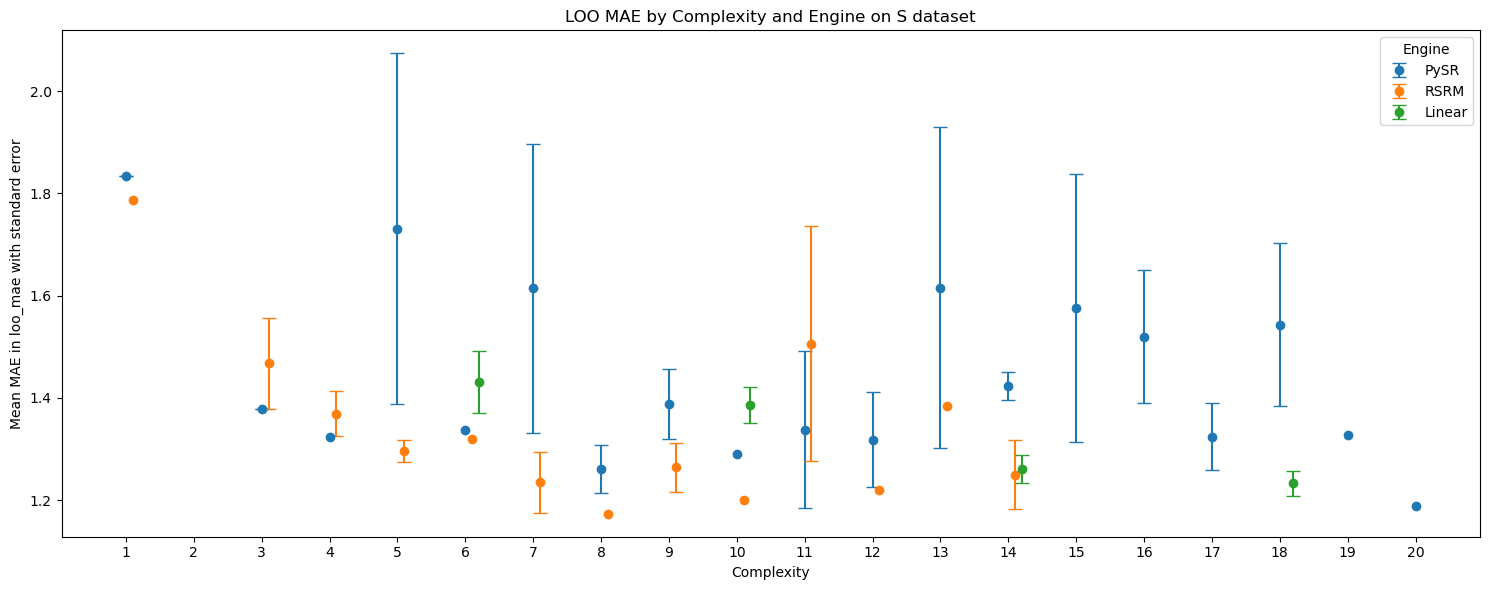

In [44]:
# Plot using scatterplot with error bars
plt.figure(figsize=(15, 6))

# Set dodge factor for error bar positions
dodge_factor = 0.1

# Assign unique offsets for each engine to dodge
engine_offsets = {
    engine: i * dodge_factor
    for i, engine in enumerate(merged_df['engine'].unique())
}

# Loop through engines to plot each group separately
for engine in merged_df['engine'].unique():
    subset = merged_df[merged_df['engine'] == engine]
    # Apply dodge to x positions
    x_positions = subset['complexity'] + engine_offsets[engine]
    plt.errorbar(
        x_positions,
        subset[f'{tt}_mean'],
        yerr=subset[f'{tt}_se'],
        fmt='o',  # Circle marker
        label=engine,
        capsize=5,  # Add caps to error bars
    )

# Adjust x-ticks
plt.xticks(
    np.arange(1, merged_df['complexity'].max() + 1, 1),  # Ticks every 2 starting at 1
    fontsize=10
)

plt.title(f'LOO {metric_name.upper()} by Complexity and Engine on {dataset_name} dataset')
plt.xlabel('Complexity')
plt.ylabel(f'Mean {metric_name.upper()} in {tt} with standard error')
plt.legend(title='Engine')
plt.tight_layout()
plt.savefig(f'Plots/{dataset_name}_comparison.png', dpi=300)
plt.show()


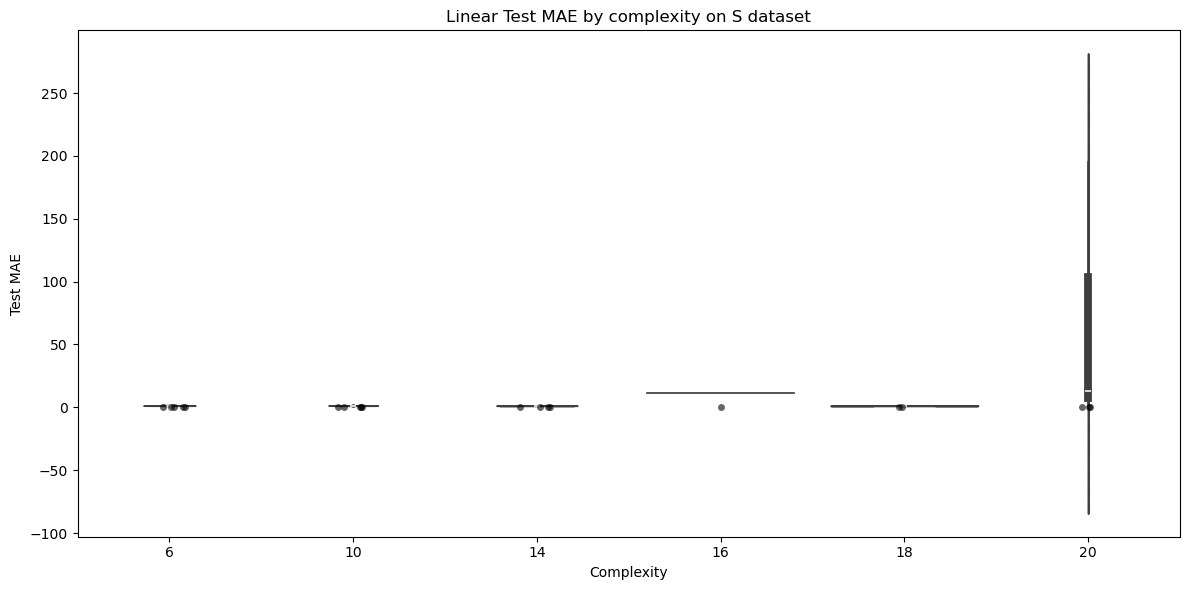

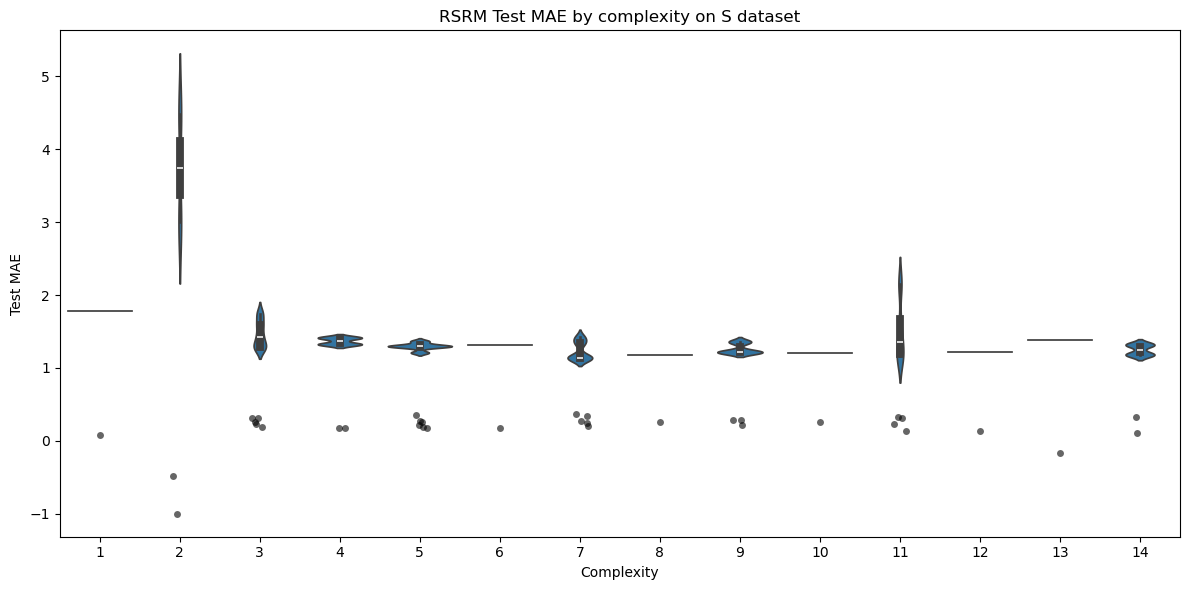

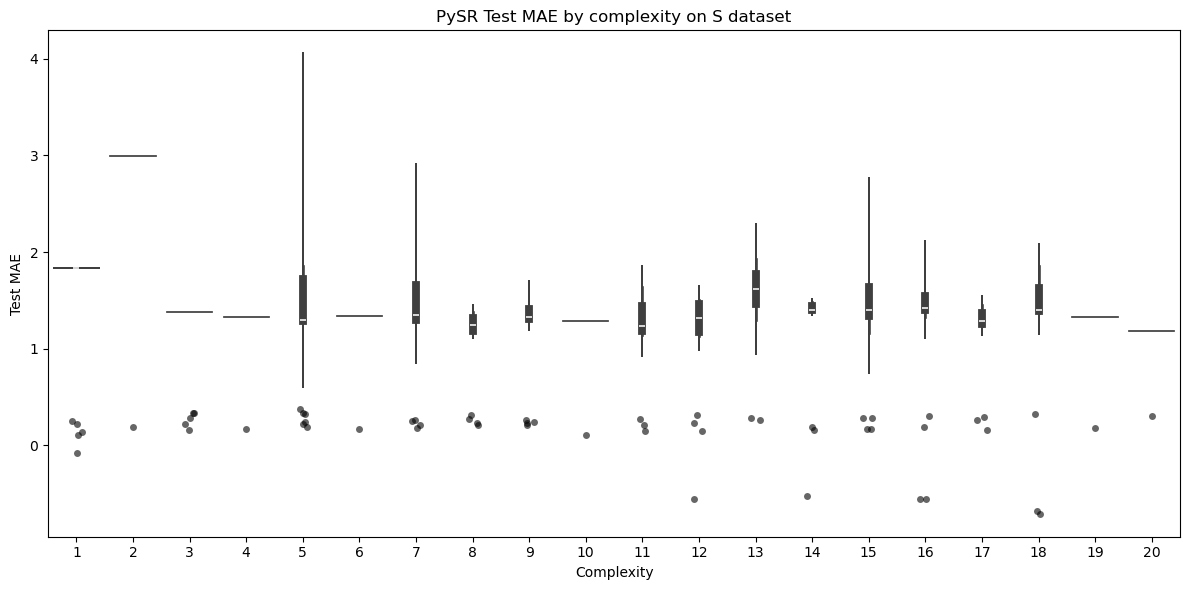

In [50]:
# Create the violin plot
for engine, df in zip(('Linear', 'RSRM', 'PySR',), (linear_df, rsrm_df[rsrm_df['test']>-1], pysr_df)):
    plt.figure(figsize=(12, 6))
    # df = df[df]
    sns.violinplot(bw_method=0.4, x='complexity', y=f'{tt}', data=df)
    sns.stripplot(x='complexity', y='test', data=df, color='k', alpha=0.6, jitter=True)
    plt.title(f'{engine} Test {metric_name.upper()} by complexity on {dataset_name} dataset')
    plt.xlabel('Complexity')
    plt.ylabel(f'Test {metric_name.upper()}')
    # plt.ylim(0,20)
    plt.tight_layout()
    plt.savefig(f'Plots/{dataset_name}_{engine}.png', dpi=300)
    plt.show()

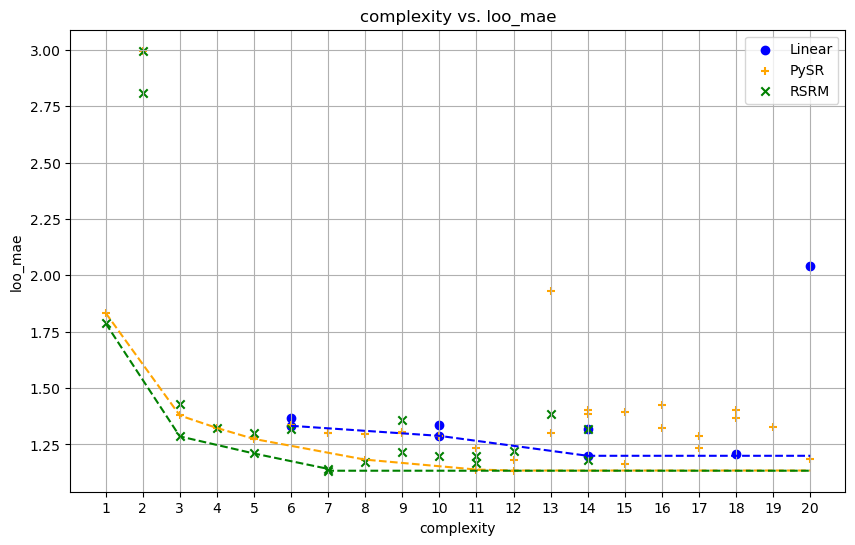

In [21]:
lower_thres = -1
upper_thres_mean = 2.5
greater_is_better = False
linear_df_top2 = linear_df.sort_values(by=f'{tt}').drop_duplicates(subset='skeleton').sort_values(by=['complexity', tt], ascending=[True, not greater_is_better]).groupby('complexity').head(2).reset_index(drop=True)
pysr_df_top2 = pysr_df.sort_values(by=f'{tt}').drop_duplicates(subset='skeleton').sort_values(by=['complexity', tt], ascending=[True, not greater_is_better]).groupby('complexity').head(2).reset_index(drop=True)
rsrm_df_top2 = rsrm_df.sort_values(by=f'{tt}').drop_duplicates(subset='skeleton').sort_values(by=['complexity', tt], ascending=[True, not greater_is_better]).groupby('complexity').head(2).reset_index(drop=True)
plot_pareto_frontier([['Linear', linear_df_top2[linear_df_top2[f'{tt}'] < 3]], ['PySR', pysr_df_top2], ['RSRM', rsrm_df_top2]], 'complexity', tt, scatter=True, minimize_y=not greater_is_better)
plt.xticks(np.arange(1, 21, 1))
plt.show()

## Latex Reporting

In [ ]:
def custom_round(x):
    if x == 0:
        return "0"
    elif x < 0.1:
        return "{:.2e}".format(x)
    else:
        return str(round(x, 2))

def round_constants_in_equation(equation):
    # Ensure the equation is treated as a single string
    if isinstance(equation, list):
        equation = ''.join(map(str, equation))
    
    # Use regex to find all numbers in the equation and round them
    def round_match(match):
        value = float(match.group())
        return f"{custom_round(value)}"
    
    # Match numbers including those in scientific notation
    rounded_equation = re.sub(r'-?\d+\.\d+(e[+-]?\d+)?', round_match, equation)
    return rounded_equation

def csv_to_latex(df, name=''):
    df = df.copy()
    # Ensure all entries in the 'Equation' column are strings
    df['equation'] = df['equation'].astype(str)
    
    df['auc'] = df['auc'].astype(float).apply(custom_round)
    df[f'{tt}'] = df[f'{tt}'].astype(float).apply(custom_round)
    
    df['equation'] = df['equation'].apply(round_constants_in_equation)
    
    # Start LaTeX table
    latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|l|r|r|r|r|}\n\\hline\n"
    latex_table += "\\textbf{Equation} & \\textbf{Complexity} & \\textbf{" + f'{metric_name.upper()}' +"} & \\textbf{Elbow} & \\textbf{Count} \\\\\n\\hline\n"
    
    # Add rows
    for index, row in df.iterrows():
        latex_table += f"{row['equation']} & {row['complexity']} & {row[f'{tt}']} & {row['auc']} & {row['count']} \\\\\n"
    
    # End LaTeX table
    latex_table += "\\hline\n\\end{tabular}\n\\caption{Pareto Frontier with LOO evaluated" + f' {metric_name.upper()} ' + "and Elbow metric for" + f' {name} and {dataset_name} dataset' + "}\n\\label{{tab:complexity_metric_equation" + f'_{name}_{dataset_name}' + "}}\n\\end{table}"
    
    return latex_table

In [30]:
for name, df in zip(('Linear', 'PySR', 'RSRM',), (linear_df_top2, pysr_df_top2, rsrm_df_top2)):
    df = compute_pareto_frontier(df, 'complexity', tt, minimize_y=not greater_is_better)
    df['auc'] = df[f'{tt}'] * df['complexity']
    print(csv_to_latex(df[['equation', 'complexity', 'auc', 'count', f'{tt}']], name))
    print('\n')
df = pd.concat([linear_df, rsrm_df, pysr_df], ignore_index=True)
df = compute_pareto_frontier(df, 'complexity', tt, minimize_y=not greater_is_better)
df = df.drop_duplicates(subset='skeleton')
df['auc'] = df[f'{tt}'] * df['complexity']
df['count'] = [all_counts[s] for s in df['skeleton']]
print(csv_to_latex(df[['equation', 'complexity', 'auc', 'count', f'{tt}']], 'All'))

\begin{table}[h!]
\centering
\begin{tabular}{|l|r|r|r|r|}
\hline
\textbf{Equation} & \textbf{Complexity} & \textbf{MAE} & \textbf{Elbow} & \textbf{Count} \\
\hline
0.53*exp(0.96*H) & 6 & 1.33 & 8.0 & 4 \\
1.16*exp(1.67*H - 0.75*P) & 10 & 1.29 & 12.88 & 3 \\
7.69*exp(-8.30e-01*D + 1.25*H - 0.85*P) & 14 & 1.2 & 16.8 & 3 \\
\hline
\end{tabular}
\caption{Pareto Frontier with LOO evaluated MAE and Elbow metric for Linear and Species richness dataset}
\label{{tab:complexity_metric_equation_Linear_s}}
\end{table}


\begin{table}[h!]
\centering
\begin{tabular}{|l|r|r|r|r|}
\hline
\textbf{Equation} & \textbf{Complexity} & \textbf{MAE} & \textbf{Elbow} & \textbf{Count} \\
\hline
P & 1 & 1.83 & 1.83 & 5 \\
exp(inv(D)) & 3 & 1.38 & 4.14 & 5 \\
0.49*exp(H) & 4 & 1.32 & 5.29 & 1 \\
(2.75 - D)**H & 5 & 1.27 & 6.37 & 1 \\
-H*(D - H) + 1.79 & 8 & 1.18 & 9.46 & 2 \\
-cond(D - 0.82, H) + exp(0.76*H) & 11 & 1.14 & 12.53 & 1 \\
-(D - H)*cond(P - Sl, H) + 1.78 & 12 & 1.13 & 13.62 & 1 \\
\hline
\end{tabular}